# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [46]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3 
import io

In [17]:
pip install pandas requests lxml

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


##### CARGAR FICHERO

In [38]:
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
response = requests.get(url)
# Verificamos la respuesta
print("Estado:", response.status_code)

Estado: 403


In [43]:
# Simulamos un navegador real enviando un User-Agent
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

response = requests.get(url, headers=headers)
response.raise_for_status()  # asegura que no hay error HTTP
print(f'Verificamos HTTP:',response.status_code)

Verificamos HTTP: 200


Cuantas tabla contiene el archivo

In [47]:
html = io.StringIO(response.text)
tables = pd.read_html(html)
print(f"Se encontraron {len(tables)} tablas.")

Se encontraron 27 tablas.


##### LEEMOS LA TABLA

In [44]:
# Leemos las tablas desde el contenido HTML
tables = pd.read_html(response.text)

# Seleccionamos la primera tabla
df = tables[0]

df

/tmp/ipykernel_2301/1577605912.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,"""Blinding Lights""",The Weeknd,5.144,29 November 2019,[1]
1,2,"""Shape of You""",Ed Sheeran,4.649,6 January 2017,[2]
2,3,"""Starboy""",The Weeknd and Daft Punk,4.211,21 September 2016,[3]
3,4,"""Sweater Weather""",The Neighbourhood,4.185,3 December 2012,[4]
4,5,"""Someone You Loved""",Lewis Capaldi,4.133,8 November 2018,[5]
...,...,...,...,...,...,...
96,97,"""Sad!""",XXXTentacion,2.457,2 March 2018,[96]
97,98,"""Someone Like You""",Adele,2.457,24 January 2011,NaN
98,99,"""Levitating""",Dua Lipa and DaBaby,2.457,1 October 2020,[97]
99,100,"""Payphone""",Maroon 5 and Wiz Khalifa,2.444,16 April 2012,NaN


##### LIMPIEZA

Eliminar `$` y `B`

In [23]:
df["Streams (billions)"] = (
    df["Streams (billions)"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace("B", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.strip()
)

# Convertir a número (float), los que no se puedan convertir serán NaN
df["Streams (billions)"] = pd.to_numeric(df["Streams (billions)"], errors="coerce")

Eliminar vacios

In [26]:
# Cambiar cadenas vacías por NaN
df = df.replace("", np.nan)

# Eliminar filas que tengan todos los valores NaN
df = df.dropna(how="all")

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                101 non-null    object 
 1   Song                101 non-null    object 
 2   Artist(s)           101 non-null    object 
 3   Streams (billions)  100 non-null    float64
 4   Release date        101 non-null    object 
 5   Ref.                99 non-null     object 
dtypes: float64(1), object(5)
memory usage: 4.9+ KB


In [28]:
df.head()

,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,"""Blinding Lights""",The Weeknd,5.144,29 November 2019,[1]
1,2,"""Shape of You""",Ed Sheeran,4.649,6 January 2017,[2]
2,3,"""Starboy""",The Weeknd and Daft Punk,4.211,21 September 2016,[3]
3,4,"""Sweater Weather""",The Neighbourhood,4.185,3 December 2012,[4]
4,5,"""Someone You Loved""",Lewis Capaldi,4.133,8 November 2018,[5]


##### SAVE

In [29]:
# Crear / abrir base de datos local
conn = sqlite3.connect("spotify.db")

# Guardar el DataFrame en una tabla
df.to_sql("most_streamed_songs", conn, if_exists="replace", index=False)

conn.close()

print("Datos guardados en la base de datos 'spotify.db', tabla 'most_streamed_songs'")

Datos guardados en la base de datos 'spotify.db', tabla 'most_streamed_songs'


Review

In [30]:
conn = sqlite3.connect("spotify.db")
cur = conn.cursor()

cur.execute("SELECT * FROM most_streamed_songs LIMIT 5;")
rows = cur.fetchall()

for r in rows:
    print(r)

conn.close()

('1', '"Blinding Lights"', 'The Weeknd', 5.144, '29 November 2019', '[1]')
('2', '"Shape of You"', 'Ed Sheeran', 4.649, '6 January 2017', '[2]')
('3', '"Starboy"', 'The Weeknd and Daft Punk', 4.211, '21 September 2016', '[3]')
('4', '"Sweater Weather"', 'The Neighbourhood', 4.185, '3 December 2012', '[4]')
('5', '"Someone You Loved"', 'Lewis Capaldi', 4.133, '8 November 2018', '[5]')


Graficado

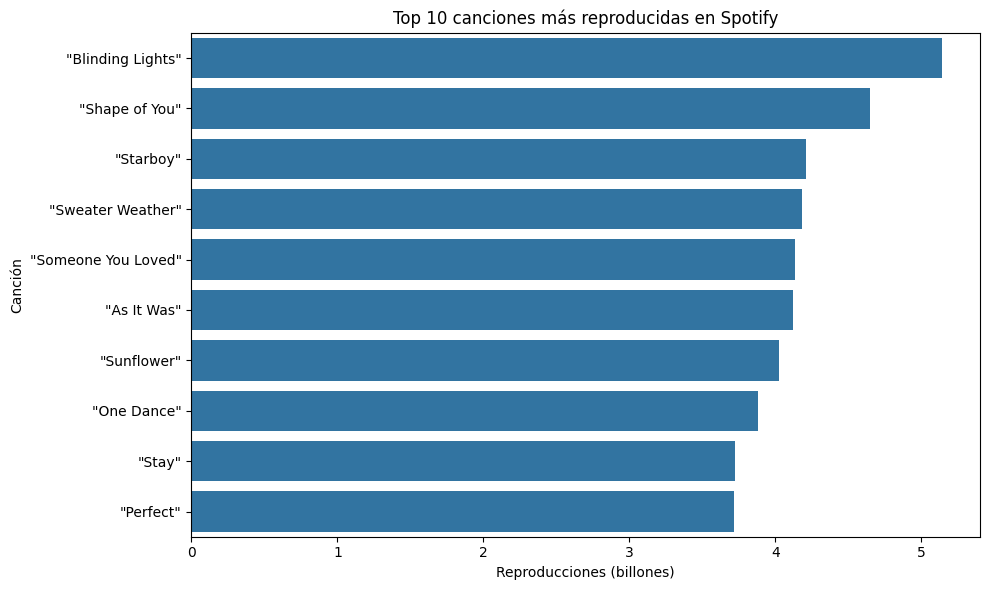

In [31]:
# Ordenamos por streams y nos quedamos con el top 10
top10 = df.sort_values("Streams (billions)", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10,
    x="Streams (billions)",
    y="Song"
)

plt.title("Top 10 canciones más reproducidas en Spotify")
plt.xlabel("Reproducciones (billones)")
plt.ylabel("Canción")
plt.tight_layout()
plt.show()

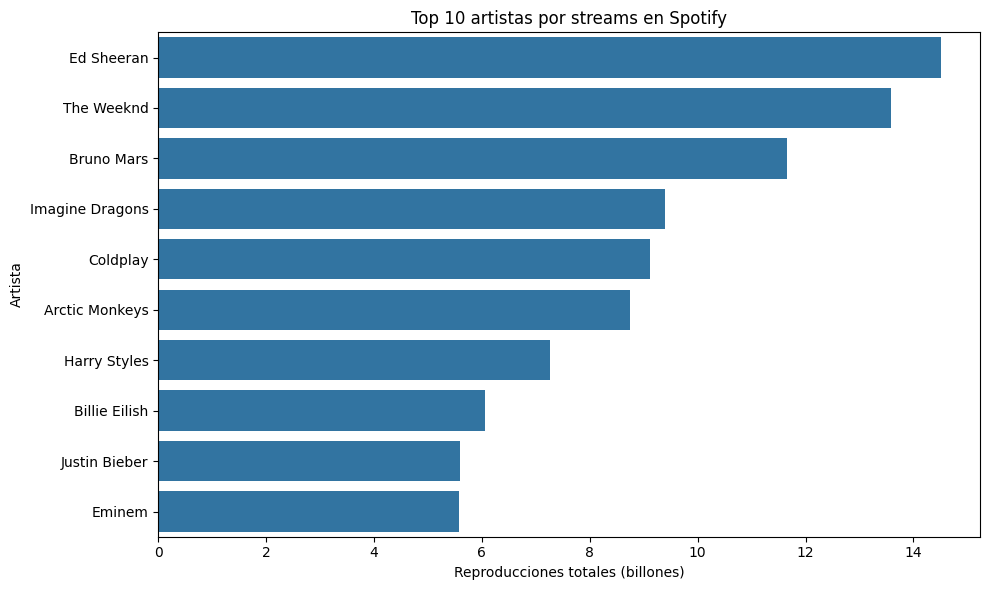

In [32]:
# Agrupar por artista y sumar streams
artist_streams = (
    df.groupby("Artist(s)")["Streams (billions)"]
    .sum()
    .sort_values(ascending=False)
    .head(10)        # top 10 artistas
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=artist_streams,
    x="Streams (billions)",
    y="Artist(s)"
)

plt.title("Top 10 artistas por streams en Spotify")
plt.xlabel("Reproducciones totales (billones)")
plt.ylabel("Artista")
plt.tight_layout()
plt.show()